In [0]:
!pip install --quiet sentence-transformers

     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 645kB 41.0MB/s 
     |████████████████████████████████| 3.8MB 53.8MB/s 
     |████████████████████████████████| 1.1MB 42.5MB/s 
     |████████████████████████████████| 890kB 49.1MB/s 


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
from sentence_transformers import SentenceTransformer
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Input, Flatten, concatenate, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from matplotlib import style
import os
import datetime
from multiprocessing import Pool
style.use('ggplot')

In [0]:
df = pd.read_csv('deep_learning_model/data/expanded_aastock_HSI_ret.csv')

# for aastock
df = df[df['news_content']!='Error']
df.dropna(subset=['news_content', 'stock_code','ret1'],inplace=True)

# for factiva
# df['tilte'] = df['news_title']

In [0]:
embed_model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')

In [0]:
X = embed_model.encode(df['title'].values)
X = np.array(X)
df['embed'] = [i.tolist() for i in X]

In [0]:
def train_model(df,threshold):
  ####################################################################################
  df['ret'] = df['ret1']  # use yesterday's close - tmr's close returns for training
  df['dir'] = df['ret'].apply(lambda x: 1 if x>threshold else 0 if x<-threshold else None)
  ####################################################################################

  df = df.sort_values(by='news_date',ignore_index=True)
  df['stock_code'] = df['stock_code'].apply(lambda x: x[:-3])
  # train test split
  train_df = df[df['news_date']<'2019']
  train_df.dropna(subset=['dir'], inplace=True)
  test_df = df[df['news_date']>='2019']
  test_df.dropna(subset=['dir'], inplace=True)
  print(train_df.shape[0],test_df.shape[0])

  tf.random.set_seed(123)
  device_name = tf.test.gpu_device_name()
  with tf.device(device_name):
    model = tf.keras.Sequential()
    model.add(Input(shape=768))


    model.add(Dense(64, activation='elu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))  

    model.add(Dense(32, activation='elu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))  

    model.add(Dense(16, activation='elu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))  
    model.add(Dense(8, activation='elu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))  
    model.add(Dense(1,activation='sigmoid'))

  tf.random.set_seed(123)
  def train(x,y):
    return (x%4 !=0)
  def val(x,y):
    return (x %4 == 0)
  def recover(x,y):
    return y


  train_dataset = tf.data.Dataset.from_tensor_slices((np.vstack(train_df['embed'].values), train_df['dir']))
  train_dataset.shuffle(400000,reshuffle_each_iteration=True)
  val_dataset = train_dataset.enumerate().filter(val).map(recover)
  train_dataset = train_dataset.enumerate().filter(train).map(recover)
  train_dataset = train_dataset.batch(8, drop_remainder=True)
  val_dataset = val_dataset.batch(8, drop_remainder=True)

  test_dataset = tf.data.Dataset.from_tensor_slices((np.vstack(test_df['embed'].values), test_df['dir']))
  test_dataset.cache()
  test_dataset.shuffle(400000)
  test_dataset = test_dataset.batch(8, drop_remainder=True)

  early_stop = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto',
      baseline=None, restore_best_weights=True
  )
  callbacks_list = [early_stop]

  filepath= "drive/My Drive/BERT/epochs_{epoch:03d}_val_acc_{val_accuracy:.3f}.hdf5"
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

  early_stop = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto',
      baseline=None, restore_best_weights=True
  )
  logdir = os.path.join("drive/My Drive/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, 
                                                        histogram_freq=3,
                                                        write_graph=True,
                                                        write_images=True)
  callbacks_list = [early_stop]

  tf.random.set_seed(123)
  model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
  history = model.fit(train_dataset,epochs=3000, validation_data=val_dataset, shuffle=True, callbacks=callbacks_list, verbose=1)
  df['score'] = model.predict(np.vstack(df['embed']))
  df.to_csv(f'drive/My Drive/BERT/hkex_{threshold: .3f}.csv', index=False)
  print(threshold)

In [0]:
threshold_list = [0.00,0.005, 0.01, 0.015, 0.02,0.025]
for threshold in threshold_list:
  train_model(df,threshold)

7039 1366
6175 1193
5169 989
4566 737
4010 564
3267 440


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [0]:
filepath= "drive/My Drive/BERT/epochs_{epoch:03d}_val_acc_{val_accuracy:.3f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto',
    baseline=None, restore_best_weights=True
)
logdir = os.path.join("drive/My Drive/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, 
                                                      histogram_freq=3,
                                                      write_graph=True,
                                                      write_images=True)
callbacks_list = [early_stop]

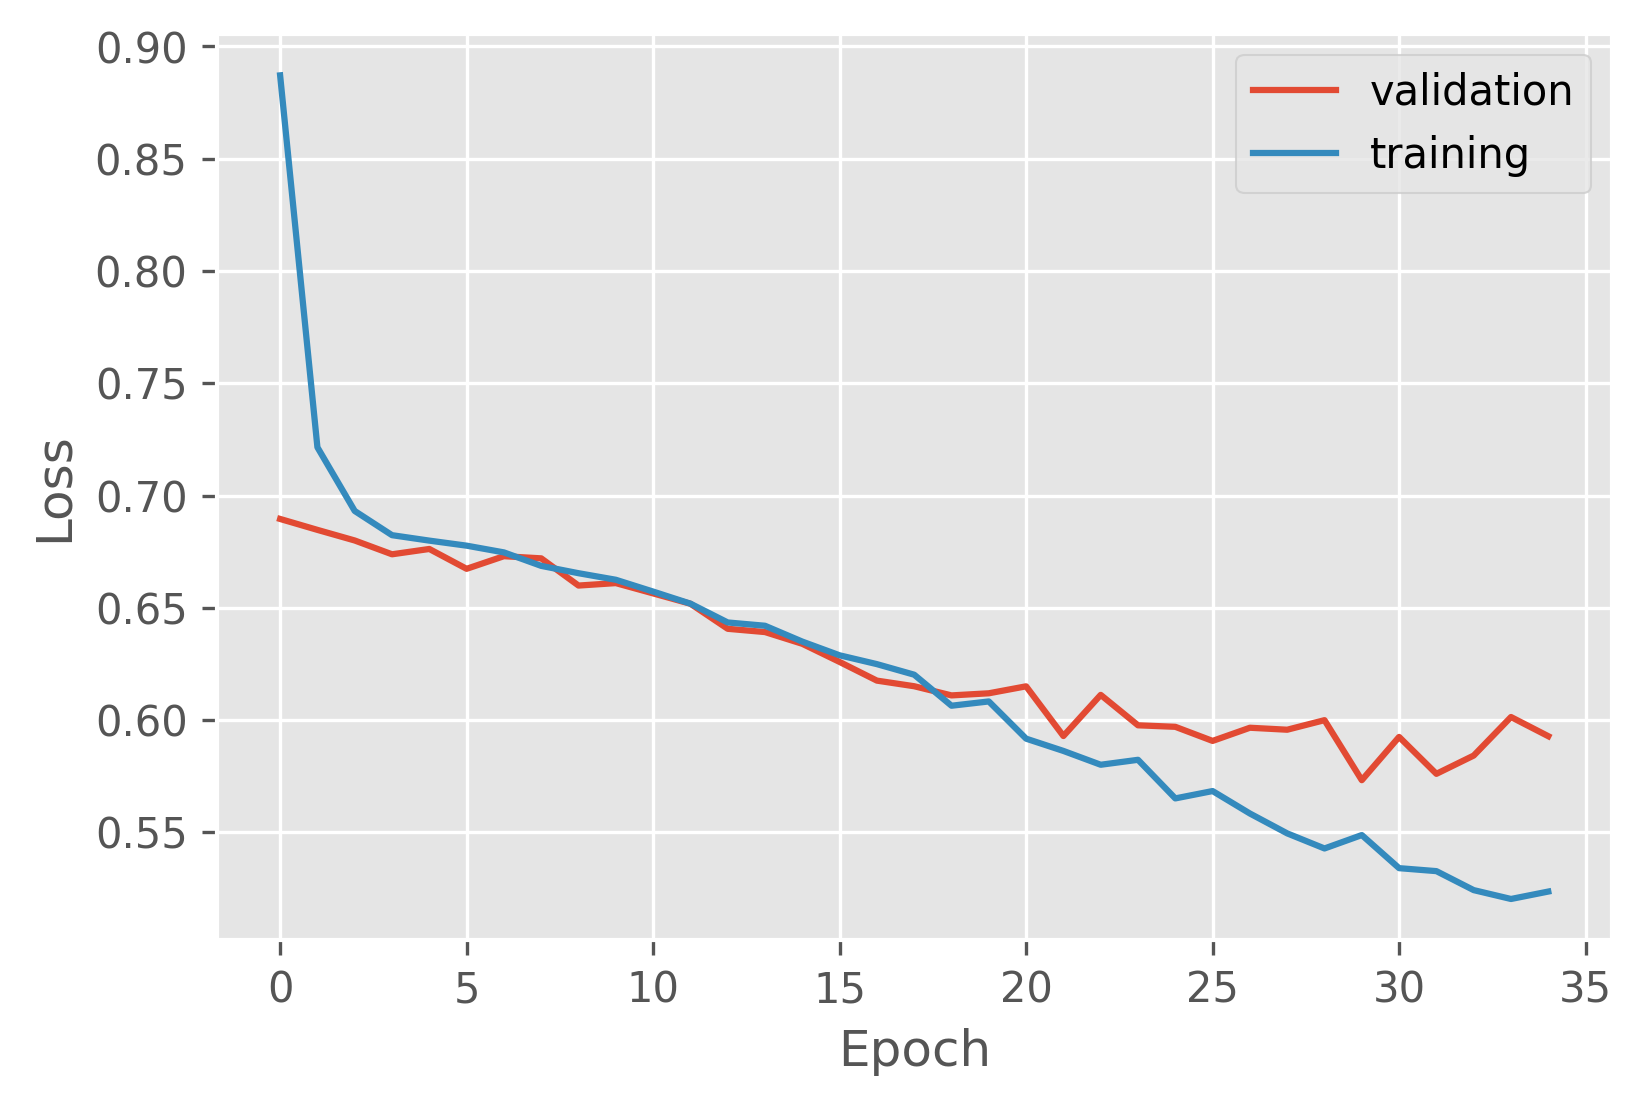

In [0]:
plt.figure(dpi=300)
plt.plot(history.history['val_loss'], label='validation')
plt.plot(history.history['loss'], label='training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.savefig("drive/My Drive/BERT/training_loss.png")

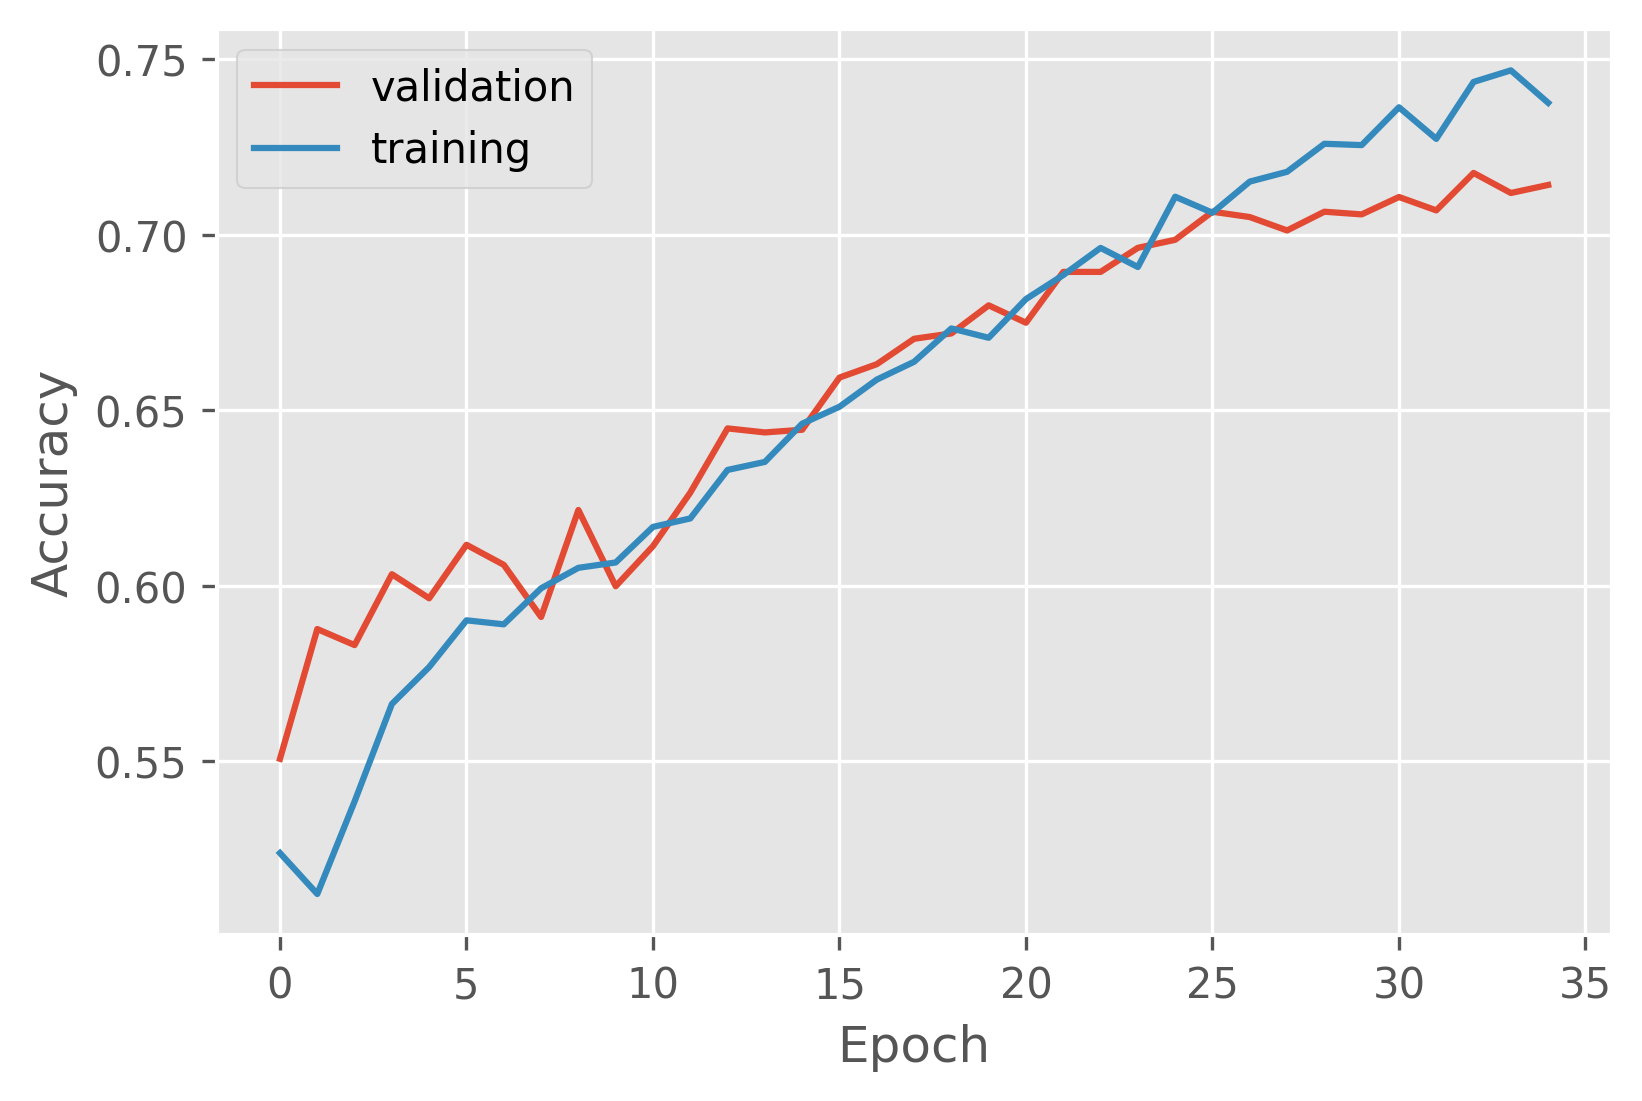

In [0]:
plt.figure(dpi=300)
plt.plot(history.history['val_accuracy'], label='validation')
plt.plot(history.history['accuracy'], label='training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("drive/My Drive/BERT/training_acc.png")

In [0]:
del df['embed']

In [0]:
df

news_id   news_dtd language  ...       ret  dir     score
0       NOW.442435  679389073       en  ...  0.000000  NaN  0.780155
1       NOW.442437  679389709       en  ...  0.036649  1.0  0.771588
2       NOW.443632  680086066       en  ...  0.034230  1.0  0.695134
3       NOW.446420  681727155       en  ... -0.051619  0.0  0.620214
4       NOW.446555  681741246       en  ...  0.007309  NaN  0.676329
...            ...        ...      ...  ...       ...  ...       ...
37754  NOW.1000328  953290739       en  ... -0.080590  0.0  0.627880
37755  NOW.1000215  953282387       en  ... -0.080590  0.0  0.394423
37756  NOW.1000203  953282050       en  ... -0.080590  0.0  0.468338
37757  NOW.1000355  953293315       en  ... -0.030435  0.0  0.698694
37758  NOW.1000317  953289637       en  ... -0.076159  0.0  0.397264

[37759 rows x 18 columns]